In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import normalvariate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import os
import pickle
from urllib import request
import gzip
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'


# Part 2: Scalar backpropagation

## Question 3

Implement the network drawn in the image below, including the weights. Perform one forward pass, up to the loss on the target value, and one backward pass. Show the relevant code in your report. Report the derivatives on all weights (including biases). Do not use anything more than plain python and the math package.

In [2]:
def initialize():
    w = [[1.,1.,1.], [-1.,-1.,-1.]]
    b = [0.,0.,0.]
    v = [[1.,1.],[-1.,-1.],[-1.,-1.]]
    c = [0., 0.]
    
    return w,b,v,c

def linear(w, b, x0, length):
    k = [0.]*length
    for j in range(len(k)):
        for i in range(len(x0)):
            k[j] += w[i][j] * x0[i]
        k[j] += b[j]
    return k

def sigmoid(x):
    return 1. / (1. + math.exp(-x))

def softmax(z):
    temp = [math.e**x for x in z ]
    b =  sum([math.e**x for x in z])
    c = [x/b for x in temp]
    return c

def loss(pred, y):
    l = 0.0
    for i in range(len(pred)): # Loop through output layer
        l += y[i] * (-math.log(pred[i]))
    return l

def sigmoid_list(lista):
    h = len(lista)* [0]
    for i in range(len(lista)):
        h[i] = sigmoid(lista[i])
    return h


def forward_pass(w, b, x0, v, c, y):
    k1 = linear(w, b, x0, 3) #linear first layer and bias
    h = sigmoid_list(k1) #first layer after sigmoid activation
    k2 = linear(v, c, h, 2) #linear second layer and bias
    pred = softmax(k2) #softmax
    return h, pred


def initialize_grads():
    dv = [[0.0, 0.0],[0.0, 0.0],[0.0, 0.0]]
    dh = [0.0, 0.0, 0.0]
    dk = [0.0, 0.0, 0.0]
    db = [0.0, 0.0, 0.0]
    dw = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    dy = [0.,0.]
    return dv, dh, dk, dw, db, dy

def backpropagate_scalar(x0, pred, y, v, h):
    dv, dh, dk, dw, db, dy = initialize_grads()
    
    for pr in range(len(pred)):
        dy[pr] = pred[pr] - y[pr]

    for i in range(len(h)):
        for j in range(len(dy)):
            dv[i][j] = dy[j] * h[i]  # derivative of V
            dh[i] += dy[j] * v[i][j]  # derivative of H

    dc = dy.copy() # Assign dC to the parameters dict

    for i in range(len(h)):
        dk[i] = dh[i]*h[i]*(1-h[i]) #derivative using sigmoid property

    for j in range(len(dk)):
        for i in range(len(x0)):
            dw[i][j] = dk[j] * x0[i] # derivative of W
        db[j] = dk[j]

    return dy, dv, dh, dk, dw, db, dc


## Question 4

Implement a training loop for your network and show that the training loss drops as training progresses.

In [3]:
def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

Epoch  0 , Loss:  0.429060447048944
Epoch  1 , Loss:  0.11892320709304856
Epoch  2 , Loss:  0.05668225864259524
Epoch  3 , Loss:  0.03578690972231778
Epoch  4 , Loss:  0.02646983712814256
Epoch  5 , Loss:  0.021017872776380894
Epoch  6 , Loss:  0.01706851449930205
Epoch  7 , Loss:  0.01391312416169035
Epoch  8 , Loss:  0.011361819697836653
Epoch  9 , Loss:  0.009325775149151313
Epoch  10 , Loss:  0.007714059416403433
Epoch  11 , Loss:  0.006436628999192955
Epoch  12 , Loss:  0.005416781270309242
Epoch  13 , Loss:  0.00459455804781279
Epoch  14 , Loss:  0.003924800526628377
Epoch  15 , Loss:  0.0033738591940957975
Epoch  16 , Loss:  0.0029166021183170718
Epoch  17 , Loss:  0.002534100463120635
Epoch  18 , Loss:  0.0022119379785996178
Epoch  19 , Loss:  0.0019389992815862472
Epoch  20 , Loss:  0.0017066036733984335
Epoch  21 , Loss:  0.0015078836336239775
Epoch  22 , Loss:  0.0013373363260645948
Epoch  23 , Loss:  0.0011904981126235567
Epoch  24 , Loss:  0.001063707086234718
Epoch  25 , 

No handles with labels found to put in legend.


Epoch  39 , Loss:  0.00029107685373021275


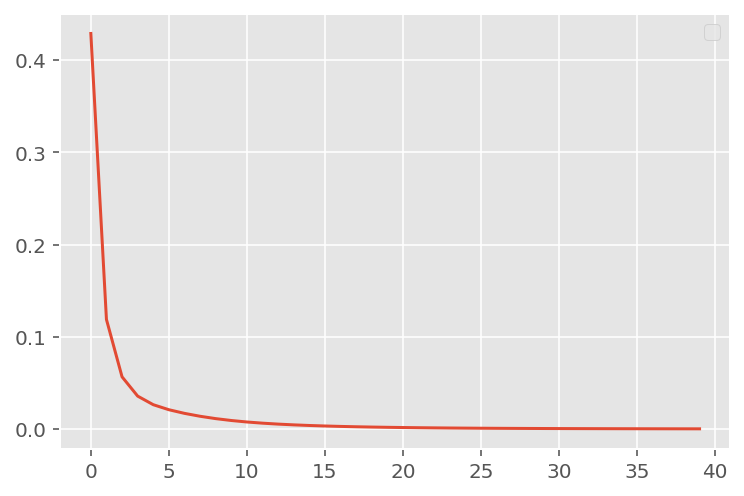

In [4]:
def update_parameters_scalar(v, c, w, b, dv, dc, dw, db, alpha: float):
    n_x, n_h, n_y = 2, 3, 2 #sizes
    
    for i in range(n_y): #output layer
        for j in range(n_h): #hidden layer
            v[j][i] -= alpha * dv[j][i]  #update second layer of weights 
        c[i] -= alpha * dc[i]  #update second layer bias

    for i in range(n_h): #hidden layer
        for j in range(n_x): #input layer
            w[j][i] -= alpha * dw[j][i]  #update first layer of weights 
        b[i] -= alpha * db[i]  #update first layer bias

    return v, c, w, b


def initialize_random():
    w = [[normalvariate(3, 1) for _ in range(3)], [normalvariate(0, 2) for _ in range(3)]]
    v = [[normalvariate(3, 1) for _ in range(2)],
            [normalvariate(0, 2) for _ in range(2)],
            [normalvariate(1, 0.5) for _ in range(2)]]
    b = [0., 0., 0.] 
    c = [0., 0.]
    
    return w, b, v, c
 

def scalar_SGD(xtrain, ytrain): 
    epochs = 40
    epoch_loss = []
    w, b, v, c = initialize_random()
    for i in range(epochs):
        for j in range(len(xtrain)):
            x0 = xtrain[j]
            if ytrain[j] == 1: y = [1, 0]
            else: y = [0, 1]
            h, pred = forward_pass(w, b, x0, v, c, y)
            l = loss(pred, y)
            dy, dv, dh, dk, dw, db, dc = backpropagate_scalar(x0, pred, y, v, h)
            v, c, w, b = update_parameters_scalar(v, c, w, b, dv, dc, dw, db, 0.001)
        epoch_loss.append(l)
        print('Epoch ', i,', Loss: ',l)

    plt.plot(epoch_loss)
    plt.legend()
    plt.show()

(xtr, ytr), (xv, yv), num_cls = load_synth()
scalar_SGD(xtr, ytr)

# Part 3: Tensor backpropagation

## Question 5 
Implement a neural network for the MNIST data. Use two linear layers as before, with a hidden layer size of 300, a sigmoid activation, and a softmax activation over the output layer, which has size 10.

In [5]:
(xtrain, ytrain), (xtest, ytest), size = load_mnist(final=True)
xtrain = xtrain/255
xtest = xtest/255

ytrain_cat = np.zeros((ytrain.size, ytrain.max()+1))
ytrain_cat[np.arange(ytrain.size),ytrain] = 1
ytest_cat = np.zeros((ytest.size, ytest.max()+1))
ytest_cat[np.arange(ytest.size),ytest] = 1

m = xtrain.shape[0]

X_train, X_test = xtrain.T, xtest.T
Y_train, Y_test = ytrain_cat.T, ytest_cat.T
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def compute_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

def forward_pass_tensor(X, params):

    cache = {}

    cache["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    cache["A1"] = sigmoid(cache["Z1"])
    cache["Z2"] = np.matmul(params["W2"], cache["A1"]) + params["b2"]
    cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

    return cache

def back_propagate(X, Y, params, cache):

    dZ2 = cache["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, cache["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(cache["Z1"]) * (1 - sigmoid(cache["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    return grads


## Question 6

Work out the vectorized version of a batched forward and backward. That is, work out how you can feed your network a batch of images in a single 3-tensor, and still perform each multiplication by a weight matrix, the addition of a bias vector, computation of the loss, etc. in a single numpy call.

Epoch 1: training cost = 0.4178208905275007, test cost = 0.39850567708045
Epoch 2: training cost = 0.33624603584582186, test cost = 0.3223802188952946
Epoch 3: training cost = 0.3069735066060317, test cost = 0.2960676272584384
Epoch 4: training cost = 0.29534907036437974, test cost = 0.2864393961837082
Epoch 5: training cost = 0.2797269734177196, test cost = 0.27538486422240266
Epoch 6: training cost = 0.2709300467015937, test cost = 0.2668132612529528
Epoch 7: training cost = 0.2526243882063171, test cost = 0.25267855941448153
Epoch 8: training cost = 0.24153596898798974, test cost = 0.23922858388314253
Epoch 9: training cost = 0.22909958756506202, test cost = 0.22928143609400395
Epoch 10: training cost = 0.2158188473771465, test cost = 0.21584950193072028
Epoch 11: training cost = 0.20745823676955905, test cost = 0.21026108444898312
Epoch 12: training cost = 0.1970364429415978, test cost = 0.2007673436375184
Epoch 13: training cost = 0.1867054104857458, test cost = 0.1902616023543221

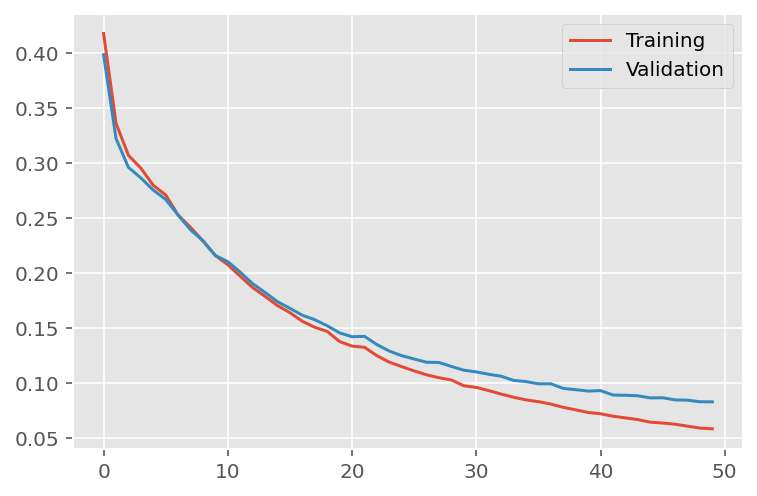

In [6]:
learning_rate = 0.05
batch_size = 32
batches = -(-m // batch_size)
epochs = 50

# initialization
params = { "W1": np.random.uniform(-1, 1, size=(300,784))* np.sqrt(1. / 784),
           "b1": np.zeros(shape=(300,1)) * np.sqrt(1. / 784),
           "W2": np.random.uniform(-1, 1, size=(10,300)) * np.sqrt(1. / 300),
           "b2": np.zeros(shape=(10,1)) * np.sqrt(1. / 300)}
train_cost_list = []
test_cost_list = []
# train
for i in range(epochs):

    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    for j in range(batches):

        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        cache = forward_pass_tensor(X, params)
        grads = back_propagate(X, Y, params, cache)

        params["W1"] = params["W1"] - learning_rate * grads["dW1"]
        params["b1"] = params["b1"] - learning_rate * grads["db1"]
        params["W2"] = params["W2"] - learning_rate * grads["dW2"]
        params["b2"] = params["b2"] - learning_rate * grads["db2"]

    cache = forward_pass_tensor(X_train, params)
    train_cost = compute_loss(Y_train, cache["A2"])
    train_cost_list.append(train_cost)
    cache = forward_pass_tensor(X_test, params)
    test_cost = compute_loss(Y_test, cache["A2"])
    test_cost_list.append(test_cost)
    print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

cache = forward_pass_tensor(X_test, params)
predictions = np.argmax(cache["A2"], axis=0)
labels = np.argmax(Y_test, axis=0)
print(classification_report(predictions, labels))


plt.plot(train_cost_list, label='Training')
plt.plot(test_cost_list, label='Validation')
plt.legend()
plt.show()

### Question 7

In [7]:
def load_mnist_v2():
    (x_train, y_train), (x_val, y_val), input_shape = load_mnist(final=False)
    x_train = x_train / 255
    x_val = x_val / 255
    
    return (x_train, y_train), (x_val, y_val)

In [49]:
#TESTE
def tuning_alpha(alpha, epochs=4, n_its=3):
    print('alpha: ', alpha)
    iter = {'train': [], 'val': []}
    for k in range(n_its):
        (x_train, y_train), (x_val, y_val) = load_mnist_v2()

        learning_rate = alpha
        batch_size = 32
        batches = -(-m // batch_size)

        # initialization
        params = { "W1": np.random.uniform(-1, 1, size=(300,784))* np.sqrt(1. / 784),
                "b1": np.zeros(shape=(300,1)) * np.sqrt(1. / 784),
                "W2": np.random.uniform(-1, 1, size=(10,300)) * np.sqrt(1. / 300),
                "b2": np.zeros(shape=(10,1)) * np.sqrt(1. / 300)}
        
        train_cost_list = []
        test_cost_list = []
        
        # train
        for i in range(epochs):

            permutation = np.random.permutation(X_train.shape[1])
            X_train_shuffled = X_train[:, permutation]
            Y_train_shuffled = Y_train[:, permutation]

            for j in range(batches):

                begin = j * batch_size
                end = min(begin + batch_size, X_train.shape[1] - 1)
                X = X_train_shuffled[:, begin:end]
                Y = Y_train_shuffled[:, begin:end]
                m_batch = end - begin

                cache = forward_pass_tensor(X, params)
                grads = back_propagate(X, Y, params, cache)

                params["W1"] = params["W1"] - learning_rate * grads["dW1"]
                params["b1"] = params["b1"] - learning_rate * grads["db1"]
                params["W2"] = params["W2"] - learning_rate * grads["dW2"]
                params["b2"] = params["b2"] - learning_rate * grads["db2"]

            cache = forward_pass_tensor(X_train, params)
            train_cost = compute_loss(Y_train, cache["A2"])
            train_cost_list.append(train_cost)
            cache = forward_pass_tensor(X_test, params)
            test_cost = compute_loss(Y_test, cache["A2"])
            test_cost_list.append(test_cost)
            print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

        cache = forward_pass_tensor(X_test, params)
        predictions = np.argmax(cache["A2"], axis=0)
        labels = np.argmax(Y_test, axis=0)
        # print(classification_report(predictions, labels))
        
        iter['train'].append(train_cost_list)
        iter['val'].append(test_cost_list)
        print(train_cost_list, test_cost_list)

    plt.plot(train_cost_list, label='Training')
    plt.plot(test_cost_list, label='Validation')
    plt.legend()
    plt.show()

    print(iter)
    return iter

alpha:  0.05
Epoch 1: training cost = 0.4205792326844882, test cost = 0.4040560034716952
Epoch 2: training cost = 0.3356012074566747, test cost = 0.3204876865856681
Epoch 3: training cost = 0.30538074498516116, test cost = 0.295368581074388
Epoch 4: training cost = 0.28578350500699784, test cost = 0.27794840306674484
[0.4205792326844882, 0.3356012074566747, 0.30538074498516116, 0.28578350500699784] [0.4040560034716952, 0.3204876865856681, 0.295368581074388, 0.27794840306674484]
Epoch 1: training cost = 0.40989299916009425, test cost = 0.3932692569976827
Epoch 2: training cost = 0.3328743258360006, test cost = 0.3187790895968705
Epoch 3: training cost = 0.3053279138284205, test cost = 0.2930918837662341
Epoch 4: training cost = 0.29058874699503395, test cost = 0.28367543644220655
[0.40989299916009425, 0.3328743258360006, 0.3053279138284205, 0.29058874699503395] [0.3932692569976827, 0.3187790895968705, 0.2930918837662341, 0.28367543644220655]
Epoch 1: training cost = 0.41592736005669184,

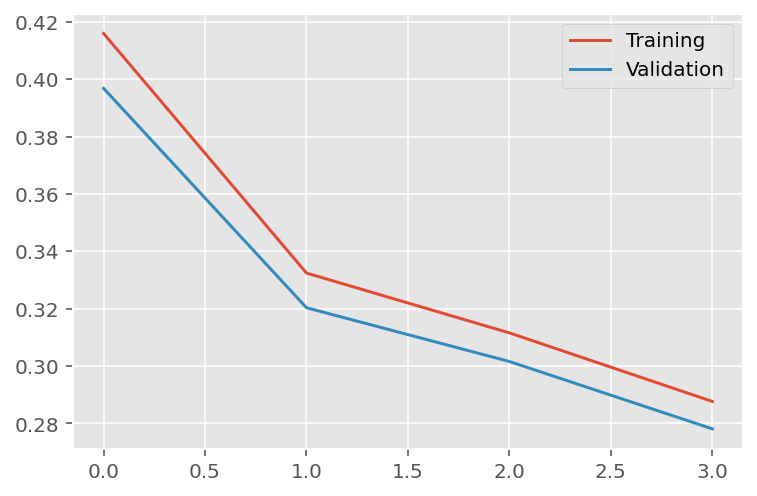

{'train': [[0.4205792326844882, 0.3356012074566747, 0.30538074498516116, 0.28578350500699784], [0.40989299916009425, 0.3328743258360006, 0.3053279138284205, 0.29058874699503395], [0.41592736005669184, 0.33242036454384744, 0.3115597789688327, 0.28766566790071485]], 'val': [[0.4040560034716952, 0.3204876865856681, 0.295368581074388, 0.27794840306674484], [0.3932692569976827, 0.3187790895968705, 0.2930918837662341, 0.28367543644220655], [0.396805291673438, 0.32033083995631306, 0.3015917265360604, 0.2781169883924335]]}


In [50]:
iter05 = tuning_alpha(0.05)

alpha:  0.05
Epoch 1: training cost = 0.41342442080930497, test cost = 0.3960071643258605
Epoch 2: training cost = 0.3379212743188733, test cost = 0.32340230783185303
Epoch 1: training cost = 0.41036253660324257, test cost = 0.39096612954699156
Epoch 2: training cost = 0.33358225410679515, test cost = 0.31949224662325104
Accuracy: 0.9086
F1 Score: 0.9071740875606521


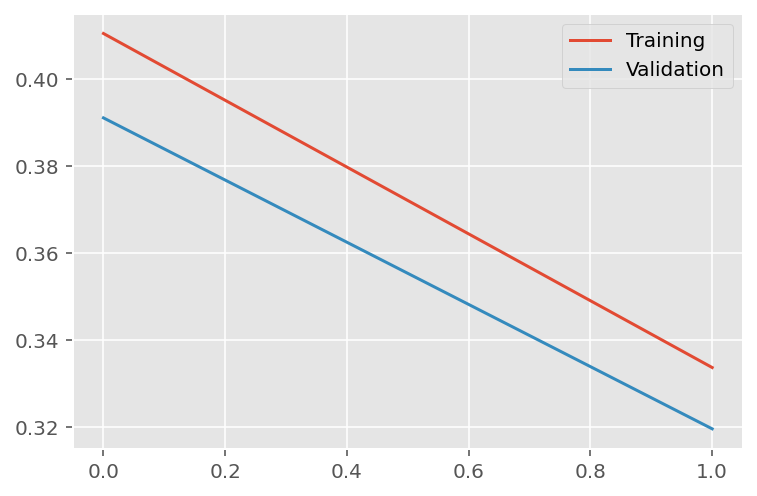

Epoch 1: training cost = 0.40590897688606836, test cost = 0.388302445856473
Epoch 2: training cost = 0.3355720936070437, test cost = 0.3203556038179578


KeyboardInterrupt: 

In [32]:
def tuning_alpha(alpha, epochs=2, n_its=3):
    print('alpha: ', alpha)
    iter = {'train': [], 'val': []}
    for k in range(n_its):
        (x_train, y_train), (x_val, y_val) = load_mnist_v2()
        
        for i in range(epochs):
            learning_rate = alpha
            batch_size = 32
            batches = -(-m // batch_size)

            # initialization
            params = { "W1": np.random.uniform(-1, 1, size=(300,784))* np.sqrt(1. / 784),
                    "b1": np.zeros(shape=(300,1)) * np.sqrt(1. / 784),
                    "W2": np.random.uniform(-1, 1, size=(10,300)) * np.sqrt(1. / 300),
                    "b2": np.zeros(shape=(10,1)) * np.sqrt(1. / 300)}
            train_cost_list = []
            test_cost_list = []
            # train
            for i in range(epochs):

                permutation = np.random.permutation(X_train.shape[1])
                X_train_shuffled = X_train[:, permutation]
                Y_train_shuffled = Y_train[:, permutation]

                for j in range(batches):

                    begin = j * batch_size
                    end = min(begin + batch_size, X_train.shape[1] - 1)
                    X = X_train_shuffled[:, begin:end]
                    Y = Y_train_shuffled[:, begin:end]
                    m_batch = end - begin

                    cache = forward_pass_tensor(X, params)
                    grads = back_propagate(X, Y, params, cache)

                    params["W1"] = params["W1"] - learning_rate * grads["dW1"]
                    params["b1"] = params["b1"] - learning_rate * grads["db1"]
                    params["W2"] = params["W2"] - learning_rate * grads["dW2"]
                    params["b2"] = params["b2"] - learning_rate * grads["db2"]

                cache = forward_pass_tensor(X_train, params)
                train_cost = compute_loss(Y_train, cache["A2"])
                train_cost_list.append(train_cost)
                cache = forward_pass_tensor(X_test, params)
                test_cost = compute_loss(Y_test, cache["A2"])
                test_cost_list.append(test_cost)
                print("Epoch {}: training cost = {}, test cost = {}".format(i+1 ,train_cost, test_cost))

        cache = forward_pass_tensor(X_test, params)
        predictions = np.argmax(cache["A2"], axis=0)
        labels = np.argmax(Y_test, axis=0)
        # print(classification_report(predictions, labels))
        print('Accuracy:',  accuracy_score(labels, predictions))
        print('F1 Score:', f1_score(labels, predictions, average='macro'))


        plt.plot(train_cost_list, label='Training')
        plt.plot(test_cost_list, label='Validation')
        plt.legend()
        plt.show() 

        iter['train'].append(train_cost_list)
        iter['val'].append(test_cost_list)

    # print()
    # cache = forward_pass_tensor(X_test, params)
    # predictions = np.argmax(cache["A2"], axis=0)
    # labels = np.argmax(Y_test, axis=0)

    # print('Accuracy:',  accuracy_score(labels, predictions))
    # print('F1 Score:', f1_score(labels, predictions, average='macro'))

    # plt.plot(train_cost_list, label='Training')
    # plt.plot(test_cost_list, label='Validation')
    # plt.legend()
    # plt.show()

        
    return iter

iter05 = tuning_alpha(0.05)
iter01 = tuning_alpha(0.01)
iter001 = tuning_alpha(0.001)

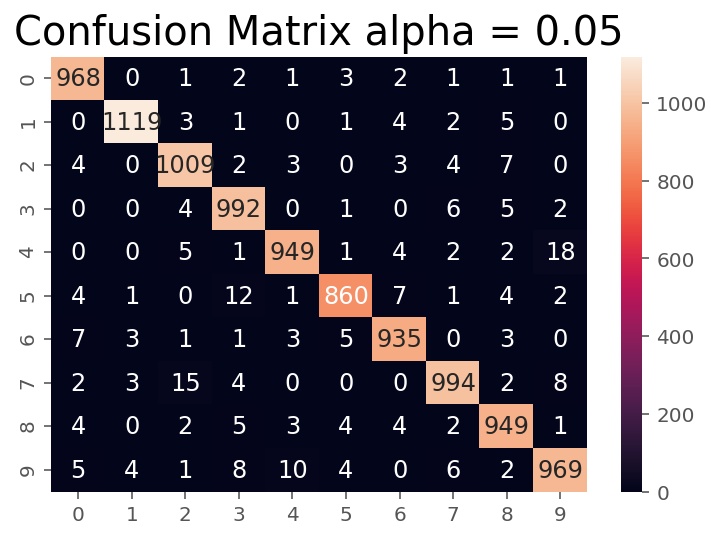

In [12]:
ax = plt.axes()
sns.heatmap(confusion_matrix(labels, predictions),fmt="d", annot=True, annot_kws={"size": 12}, ax=ax)

ax.set_title('Confusion Matrix alpha = 0.05', fontsize=20)
plt.show()

In [18]:
#mean and std for train and test with different alphas
m_tr05 = np.asarray(iter05['train']).mean(axis=0)
sd_tr05 = np.asarray(iter05['train']).std(axis=0)
m_te05 = np.asarray(iter05['val']).mean(axis=0)
sd_te05 = np.asarray(iter05['val']).std(axis=0)

m_tr01 = np.asarray(iter01['train']).mean(axis=0)
sd_tr01 = np.asarray(iter01['train']).std(axis=0)
m_te01 = np.asarray(iter01['val']).mean(axis=0)
sd_te01 = np.asarray(iter01['val']).std(axis=0)

m_tr001 = np.asarray(iter001['train']).mean(axis=0)
sd_tr001 = np.asarray(iter001['train']).std(axis=0)
m_te001 = np.asarray(iter001['val']).mean(axis=0)
sd_te001 = np.asarray(iter001['val']).std(axis=0)

### Question 7.3

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

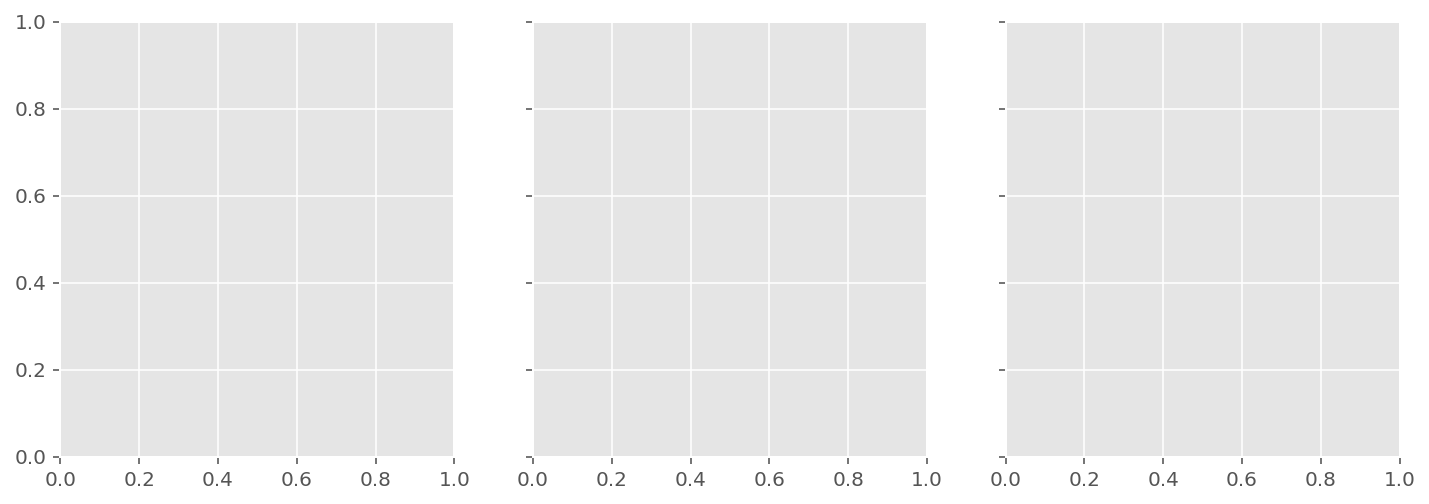

In [19]:
t = np.arange(1, 6)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4))

ax0.plot(t, m_tr05, lw=2, label='Train', color='blue')
ax0.plot(t, m_te05, lw=2, label='Val', color='red')
ax0.fill_between(t, m_tr05+sd_tr05, m_tr05-sd_tr05, facecolor='blue', alpha=0.5)
ax0.fill_between(t, m_te05+sd_te05, m_te05-sd_te05, facecolor='red', alpha=0.5)
ax0.set_title(r'alpha: 0.05')

ax1.plot(t, m_tr01, lw=2, label='Train', color='blue')
ax1.plot(t, m_te01, lw=2, label='Val', color='red')
ax1.fill_between(t, m_tr01+sd_tr01, m_tr01-sd_tr01, facecolor='blue', alpha=0.5)
ax1.fill_between(t, m_te01+sd_te01, m_te01-sd_te01, facecolor='red', alpha=0.5)
ax1.set_title(r'alpha: 0.01')

ax2.plot(t, m_tr001, lw=2, label='Train', color='blue')
ax2.plot(t, m_te001, lw=2, label='Val', color='red')
ax2.fill_between(t, m_tr001+sd_tr001, m_tr001-sd_tr001, facecolor='blue', alpha=0.5)
ax2.fill_between(t, m_te001+sd_te001, m_te001-sd_te001, facecolor='red', alpha=0.5)
ax2.set_title(r'alpha: 0.001')

ax2.legend(loc='upper right')
ax1.set_xlabel('Epochs')
ax0.set_ylabel('Cross Entropy Loss')
ax0.grid()
ax1.grid()
ax2.grid()

fig.suptitle('Effect of Learning Rate on Training and Validation Loss')
plt.show()

### Question 7.4

In [ ]:
(x_train, y_train), (x_test, y_test), input_shape = load_mnist(final=True)
x_train = x_train / 255
x_test = x_test / 255

tuning_alpha(0.05)